# TensorFlow训练石头剪刀布模型

在本次实验中我们需要进行石头剪刀布图片库的神经网络训练。[石头剪刀布数据集](https://laurencemoroney.com/datasets.html)包含了来自不同的种族、年龄和性别的不同手势图片。

## 下载数据集
首先下载石头剪刀布的训练集和测试集，这里我把文件下载到当前文件夹中的zip文件夹“./zip/”，如果需要更改则可修改“-O”后面的路径：

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/learning-datasets/rps.zip -O ./zip/rps.zip
!wget --no-check-certificate https://storage.googleapis.com/learning-datasets/rps-test-set.zip -O ./zip/rps-test-set.zip

--2024-06-07 06:29:21--  https://storage.googleapis.com/learning-datasets/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.180.27, 142.250.187.219, 142.250.187.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.180.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘./zip/rps.zip’

./zip/rps.zip         0%[                    ]  80.04K   347KB/s               

./zip/rps.zip       100%[===================>] 191.38M  30.8MB/s    in 7.5s    

2024-06-07 06:29:29 (25.5 MB/s) - ‘./zip/rps.zip’ saved [200682221/200682221]

--2024-06-07 06:29:29--  https://storage.googleapis.com/learning-datasets/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.204.91, 142.250.179.251, 142.250.187.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.204.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘./zip/rps-test-set.zip’

./zip/rps-test-set. 100%[===================>]  28.15M  23.1MB/s    in 1.2s    

2024-06-07 06:29:31 (23.1 MB/s) - ‘./zip/rps-test-set.zip’ saved [29516758/29516758]



![image-20240607143750287](assets/image-20240607143750287.png)

然后解压下载的数据集到当前文件夹中的ml文件夹“./ml/”中，

In [6]:
import os
import zipfile
 # 解压rps.zip
local_zip = './zip/rps.zip' 
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./ml/')  # 解压后的输出路径
zip_ref.close()

# 解压rps-test-set.zip
local_zip = './zip/rps-test-set.zip'  
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./ml/')  # 解压后的输出路径
zip_ref.close()

![image-20240607144423849](assets/image-20240607144423849.png)

检测数据集的解压结果，并打印相关信息。

In [7]:
rock_dir = os.path.join('./ml/rps/rock')
paper_dir = os.path.join('./ml/rps/paper')
scissors_dir = os.path.join('./ml/rps/scissors')
# 查看各训练集图片数量
print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))
# 查看各训练集的前10张图片的文件名
rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock04-038.png', 'rock07-k03-080.png', 'rock03-109.png', 'rock04-110.png', 'rock02-073.png', 'rock04-008.png', 'rock04-048.png', 'rock01-000.png', 'rock04-059.png', 'rock02-011.png']
['paper05-048.png', 'paper03-028.png', 'paper01-051.png', 'paper03-033.png', 'paper04-038.png', 'paper06-067.png', 'paper03-008.png', 'paper06-008.png', 'paper02-024.png', 'paper07-035.png']
['scissors04-107.png', 'testscissors02-072.png', 'scissors01-112.png', 'testscissors03-077.png', 'testscissors01-060.png', 'scissors04-101.png', 'scissors01-075.png', 'testscissors01-061.png', 'testscissors01-065.png', 'scissors02-102.png']


## 验证下载的数据集
各打印两张石头剪刀布训练集图片

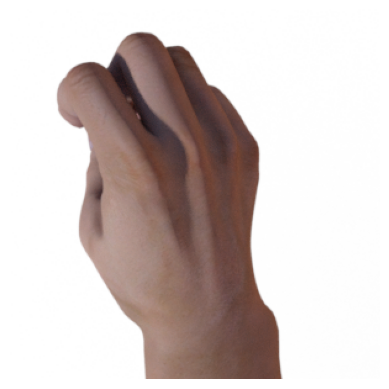

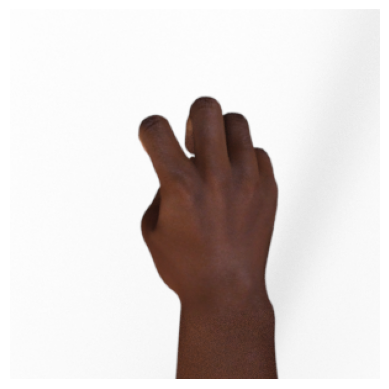

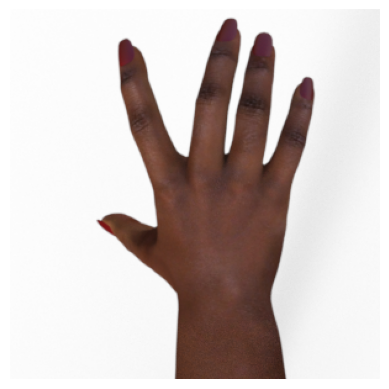

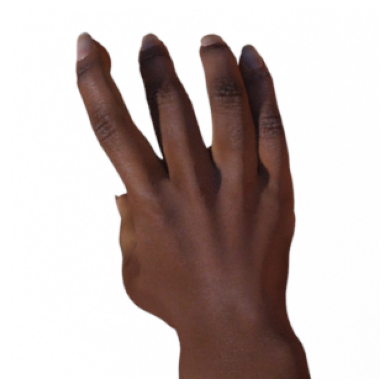

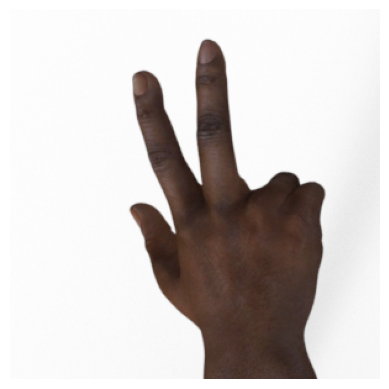

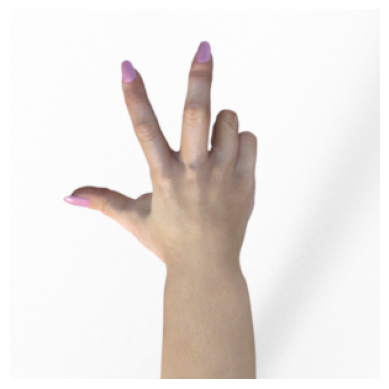

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2
# 从各训练集中各选取两张图片
next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]
# 显示图片
for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## 模型训练
接着我们调用TensorFlow的keras进行数据模型的训练和评估。Keras是开源人工神经网络库，TensorFlow集成了keras的调用接口，可以方便的使用。

ImageDataGenerator是Keras中图像预处理的类，经过预处理使得后续的训练更加准确。

Sequential定义了序列化的神经网络，封装了神经网络的结构，有一组输入和一组输出。可以定义多个神经层，各层之间按照先后顺序堆叠，前一层的输出就是后一层的输入，通过多个层的堆叠，构建出神经网络。

神经网络两个常用的操作：卷积和池化。由于图片中可能包含干扰或者弱信息，使用卷积处理（此处的Conv2D函数）使得我们能够找到特定的局部图像特征（如边缘）。此处使用了3X3的滤波器（通常称为垂直索伯滤波器）。而池化（此处的MaxPooling2D）的作用是降低采样，因为卷积层输出中包含很多冗余信息。池化通过减小输入的大小降低输出值的数量。

Dense的操作即全连接层操作，本质就是由一个特征空间线性变换到另一个特征空间。Dense层的目的是将前面提取的特征，在dense经过非线性变化，提取这些特征之间的关联，最后映射到输出空间上。Dense这里作为输出层。

In [1]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
# 图片预处理
TRAINING_DIR = "./ml/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "./ml/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)
# 定义模型架构
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# 编译模型
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# 用训练数据拟合
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)
# 将模型以h5格式保存到rps.h5文件中
model.save("rps.h5")

2024-06-07 07:17:15.153538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-07 07:17:15.153593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


2024-06-07 07:17:26.759541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-07 07:17:26.759581: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-07 07:17:26.759607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-975789): /proc/driver/nvidia/version does not exist
2024-06-07 07:17:26.760087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

2024-06-07 07:17:28.150497: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34020000 exceeds 10% of free system memory.


Epoch 1/25


2024-06-07 07:17:30.304999: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34020000 exceeds 10% of free system memory.
2024-06-07 07:17:30.325655: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 706535424 exceeds 10% of free system memory.
2024-06-07 07:17:31.370691: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 176633856 exceeds 10% of free system memory.
2024-06-07 07:17:31.512942: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 167215104 exceeds 10% of free system memory.


20/20 [==============================] - 126s 6s/step - loss: 1.4384 - accuracy: 0.3437 - val_loss: 1.0974 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 120s 6s/step - loss: 1.1248 - accuracy: 0.3710 - val_loss: 1.0862 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 120s 6s/step - loss: 1.0755 - accuracy: 0.4266 - val_loss: 1.0054 - val_accuracy: 0.3414
Epoch 4/25
20/20 [==============================] - 120s 6s/step - loss: 1.0560 - accuracy: 0.4524 - val_loss: 1.0154 - val_accuracy: 0.5565
Epoch 5/25
20/20 [==============================] - 118s 6s/step - loss: 0.9129 - accuracy: 0.5516 - val_loss: 0.4944 - val_accuracy: 0.7419
Epoch 6/25
20/20 [==============================] - 119s 6s/step - loss: 0.8844 - accuracy: 0.6024 - val_loss: 0.4185 - val_accuracy: 0.9382
Epoch 7/25
20/20 [==============================] - 118s 6s/step - loss: 0.6839 - accuracy: 0.7075 - val_loss: 0.4595 - val_accuracy: 0.6855
Epoch 8/25
20/20 [======

![image-20240607161629837](assets/image-20240607161629837.png)

## 模型评估验证
完成模型训练后，我们绘制训练和验证结果的相关信息，验证生成模型的性能。

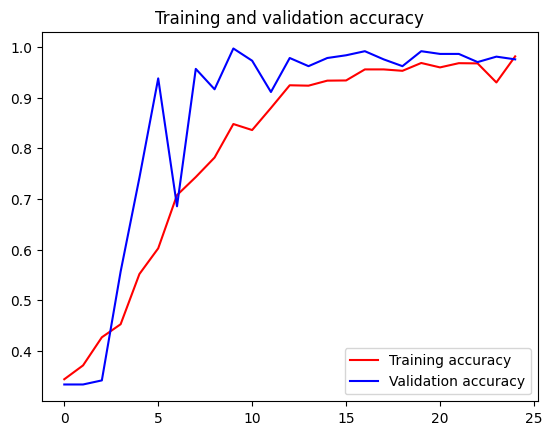

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

从上面的图表我们可以看到，随着训练的进行，训练和验证准确率都在增加，且最终都到达接近100%的准确率。